# Predicting Batted Ball Outcome with MLB Swing Data

#### Author: Ryan Lucero

# Overview

In this notebook, we will predict batted ball outcomes using Statcast's new swing data as well as pitch metrics, and other situational data. This project is inspired by Nick Wan's kaggle contest (https://www.kaggle.com/competitions/nwds-batted-balls/overview). During th 2024 season, MLB was able to start tracking swing speed and length, and this contest was designed to explore the interaction between the two new swing metrics within a baseball context. The goal is to predict batted ball outcomes and to evaluate the model's success using AUC. 

## Data

This dataset includes only batted balls in play and home runs from the beginning of the 2024 season up to the All-Star game. From Nick Wan's contest:

*The data comes from MLB Statcast via Baseball Savant. Please reference the Baseball Savant Statcast Search CSV documentation for a data dictionary:*
https://baseballsavant.mlb.com/csv-docs

*Some columns are unique to this competition. These are:*

* uid: a unique ID for each row in the dataset
* is_lhp: whether a pitcher throws with their left hand
* is_lhb: whether a batter hits with a left-handed stance
* spray_angle: calculated via pybaseball and is described as

 > *Spray angle is the raw left-right angle of the hit - Adjusted spray angle flips the sign for left handed batters, making it a push/pull angle. Inspired by this Alan Nathan post (https://baseball.physics.illinois.edu/carry-v2.pdf). The formula to transform hit coordinates to spray angle used was obtained from this blog post (https://baseballwithr.wordpress.com/2018/01/15/chance-of-hit-as-function-of-launch-angle-exit-velocity-and-spray-angle/).*

* outcome: the result of the batted ball; can be 'out', 'single', 'double', 'triple', or 'home_run'
* outcome_code: for convenience and clarity, the outcome column is represented with integers where 0='out', 1='single', 2='double', 3='triple', and 4='home_run'.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import optuna

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from scipy.stats import randint

from xgboost import XGBClassifier, plot_importance



# Data Exploration and Feature Engineering

In [3]:
df = pd.DataFrame(pd.read_csv('batted_balls.csv'))

In [4]:
df.shape

(50000, 41)

In [5]:
df.columns

Index(['uid', 'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
       'game_type', 'is_lhp', 'is_lhb', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'is_top', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'pitch_number', 'pitch_name',
       'spin_axis', 'spray_angle', 'bat_speed', 'swing_length', 'outcome',
       'outcome_code'],
      dtype='object')

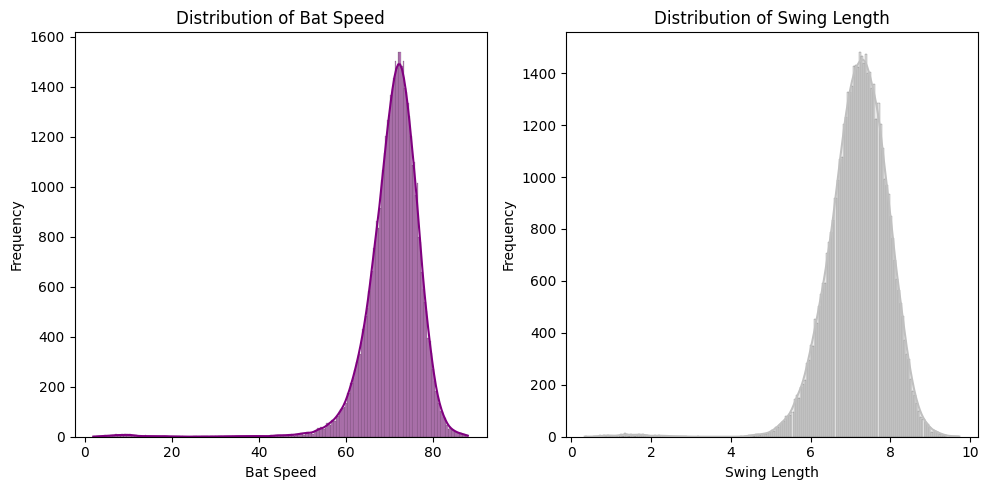

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(df['bat_speed'], ax=axes[0], kde=True, color='purple')
axes[0].set_title('Distribution of Bat Speed')
axes[0].set_xlabel('Bat Speed')
axes[0].set_ylabel('Frequency')

sns.histplot(df['swing_length'], ax=axes[1], kde=True, color='silver')
axes[1].set_title('Distribution of Swing Length')
axes[1].set_xlabel('Swing Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Small hump at the front of the histogram indicates bunts or other non-full swings. I will remove those later (after hot encoding) as I want to limit the data set to competative swings. Bunts should be evaluated with a separate model.

In [7]:
# Feature Engineering - Swing acceleration

df['bat_speed_fps'] = df['bat_speed'] * 5280 / 3600 #converts bat speed from mph to fps
df['bat_acceleration'] = df['bat_speed_fps']**2 / (2 * df['swing_length']) #calculates accleraion in ft/s^2 assuming constant acceleration over the swing length

In [8]:
df['pitch_type'].unique()

array(['FF', 'SL', 'SI', 'ST', 'FC', 'CH', 'CU', 'FS', 'SV', 'KC', 'EP',
       'FA', 'FO', 'KN', 'SC'], dtype=object)

In [9]:
##Implement One-Hot Encoder for pitch type###
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
pitch_types_encoded = encoder.fit_transform(df[['pitch_type']])
df_encoded = pd.DataFrame(pitch_types_encoded, columns=encoder.get_feature_names_out(['pitch_type']))
df = pd.concat([df, df_encoded], axis=1)

df.head()

,uid,pitch_type,release_speed,release_pos_x,release_pos_z,game_type,is_lhp,is_lhb,balls,strikes,...,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_KC,pitch_type_KN,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV
0,0,FF,93.3,2.01,5.77,R,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,SL,86.1,2.00,5.84,R,1,1,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,SI,92.7,-1.67,6.54,R,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,FF,92.7,1.97,5.78,R,1,0,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,SL,85.7,2.13,5.80,R,1,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
###Implementing One-Hot Encoder for pitch category - Fastball (FB), Breaking Ball (BB), Off Speed (OS) ###

pitch_type_mapping = {
        'FF': 'FB', 'SI': 'FB', 'FA': 'FB',
        'SL': 'BB', 'FC': 'BB', 'ST': 'BB', 'CU': 'BB', 'FS': 'BB', 'KC': 'BB', 'SV': 'BB', 'CS': 'BB',
        'CH': 'OS', 'FS': 'OS', 'KN': 'OS', 'EP': 'OS', 'FO': 'OS', 'SC': 'OS'
    }

df['pitch_type_grouping'] = df['pitch_type'].map(pitch_type_mapping)

pitch_groups_encoded = encoder.fit_transform(df[['pitch_type_grouping']])
df_encoded = pd.DataFrame(pitch_groups_encoded, columns=encoder.get_feature_names_out(['pitch_type_grouping']))
df = pd.concat([df, df_encoded], axis=1)

df.head()

,uid,pitch_type,release_speed,release_pos_x,release_pos_z,game_type,is_lhp,is_lhb,balls,strikes,...,pitch_type_KN,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV,pitch_type_grouping,pitch_type_grouping_BB,pitch_type_grouping_FB,pitch_type_grouping_OS
0,0,FF,93.3,2.01,5.77,R,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,FB,0.0,1.0,0.0
1,1,SL,86.1,2.00,5.84,R,1,1,1,2,...,0.0,0.0,0.0,1.0,0.0,0.0,BB,1.0,0.0,0.0
2,2,SI,92.7,-1.67,6.54,R,0,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,FB,0.0,1.0,0.0
3,3,FF,92.7,1.97,5.78,R,1,0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,FB,0.0,1.0,0.0
4,5,SL,85.7,2.13,5.80,R,1,0,0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,BB,1.0,0.0,0.0


In [11]:
### Removing Bunts from the dataset ###

bunt_mask = (df['swing_length'] <= 4) & (df['bat_speed'] <= 40)

df = df[~bunt_mask]

In [12]:
df['pitch_type'].value_counts()

pitch_type
FF    14656
SI     9561
SL     7532
CH     5749
FC     4248
ST     2774
CU     2758
FS     1520
KC      655
SV      149
KN       71
FA       65
EP       50
FO       12
SC        3
Name: count, dtype: int64

In [13]:
df['pitch_type_grouping'].value_counts()

pitch_type_grouping
FB    24282
BB    18116
OS     7405
Name: count, dtype: int64

In [14]:
### Removing Uneccesary/Duplicate Columns ###
df = df.drop(columns='game_year') #all data is from 2024
df = df.drop(columns='game_type') #all the the data is from Regular Season games ('R')
df = df.drop(columns='uid') 
df = df.drop(columns='outcome')
df = df.drop(columns='pitch_type')
df = df.drop(columns='pitch_type_grouping')
df = df.drop(columns='pitch_name')
df = df.drop(columns='bat_speed_fps')

In [15]:
df['outcome_code'].value_counts()

outcome_code
0    33845
1    10347
2     3162
4     2166
3      283
Name: count, dtype: int64

In [16]:
df.groupby(['outcome_code'])[['bat_speed', 'swing_length', 'bat_acceleration']].mean()

,bat_speed,swing_length,bat_acceleration
outcome_code,,,
0,70.750471,7.208862,753.903759
1,70.586064,7.128774,758.838643
2,72.520464,7.330148,777.301414
3,72.369195,7.216233,786.475341
4,74.769918,7.518568,803.860285


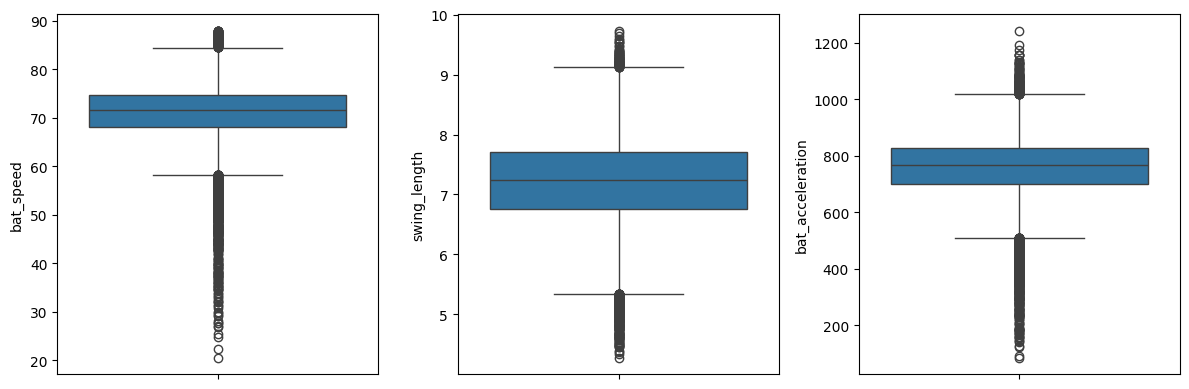

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=False)
sns.boxplot(df['bat_speed'], ax=axes[0])
sns.boxplot(df['swing_length'], ax=axes[1])
sns.boxplot(df['bat_acceleration'], ax=axes[2])

plt.tight_layout()

plt.show()

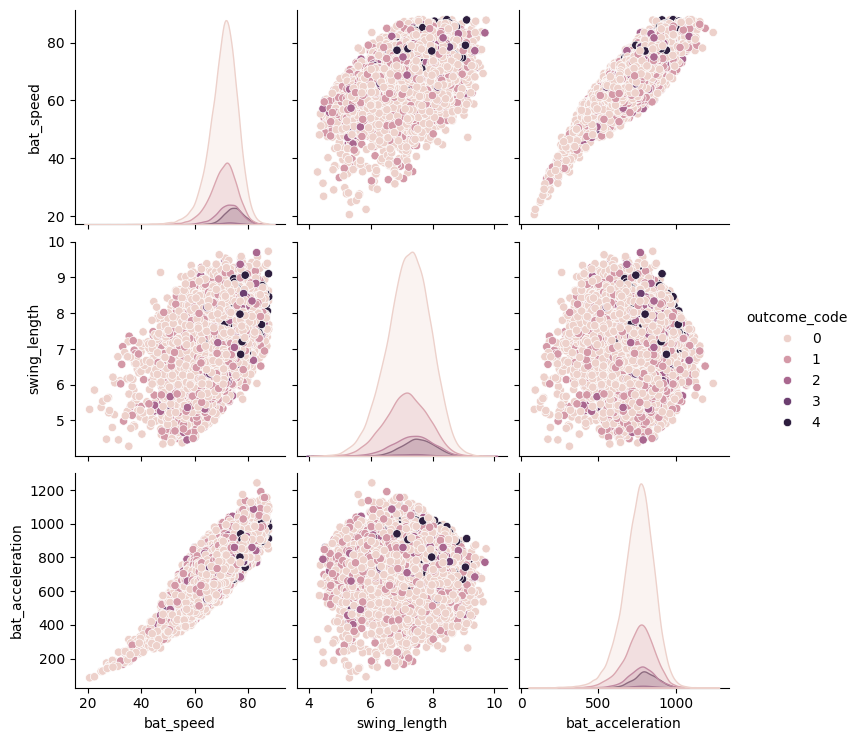

In [18]:
sns.pairplot(data=df[['bat_speed', 'swing_length', 'bat_acceleration', 'outcome_code']], hue='outcome_code')

As expected, faster swings, and swings with higher accleration result in more extra base hits.

In [19]:
### Feature Engineering ###

df['opposite_hand'] = df['is_lhp'] != df['is_lhb']
df['on_base'] = df['on_1b'] + df['on_2b'] + df['on_3b']
df['pitch_speed_diff'] = df['release_speed'] - df['effective_speed']
df['horizontal_movement'] = df['pfx_x'] * df['release_extension']
df['vertical_movement'] = df['pfx_z'] * df['release_extension']
df['total_movement'] = np.sqrt(df['horizontal_movement']**2 + df['vertical_movement']**2)
df['is_pulled'] = (np.where(df['is_lhb'], df['spray_angle'] > 0, df['spray_angle'] < 0))

df['pitch_speed_diff'] = df['release_speed'] - df['effective_speed']
df['pitch_location'] = np.sqrt(df['plate_x']**2 + df['plate_z']**2)
df['count_pressure'] = df['balls'] - df['strikes'] + 1
df['bat_pitch_speed_ratio'] = df['bat_speed'] / df['release_speed']
df['swing_efficiency'] = df['bat_speed'] / df['swing_length']
df['movement_complexity'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
df['release_angle'] = np.arctan2(df['release_pos_z'], df['release_pos_x'])
df['approach_angle'] = np.arctan2(df['vz0'], np.sqrt(df['vx0']**2 + df['vy0']**2))
df['spin_efficiency'] = np.abs(np.sin(np.radians(df['spin_axis'])))
df['magnus_effect'] = df['release_spin_rate'] * df['movement_complexity']
df['break_time'] = df['release_extension'] / df['effective_speed']
df['tunneling_time'] = 0.15 * df['release_speed'] / (df['movement_complexity']+1e-8) # adding small number to avoid division by zero
df['stance_advantage'] = ((df['is_lhp'] == 1) & (df['is_lhb'] == 0)) | ((df['is_lhp'] == 0) & (df['is_lhb'] == 1))
df['pitch_speed_change'] = df.groupby('pitch_number')['release_speed'].diff()
df['horizontal_change'] = df.groupby('pitch_number')['pfx_x'].diff()
df['vertical_change'] = df.groupby('pitch_number')['pfx_z'].diff()
df['baserunner_pressure'] = df['on_1b'] + 2*df['on_2b'] + 3*df['on_3b']
df['late_inning_pressure'] = (df['inning'] >= 7).astype(int)
df['release_x_deviation'] = df['release_pos_x'] - df['release_pos_x'].mean()
df['release_z_deviation'] = df['release_pos_z'] - df['release_pos_z'].mean()
df['relative_height'] = (df['plate_z'] - df['sz_bot']) / (df['sz_top'] - df['sz_bot'])
df['is_strike'] = ((df['plate_x'].between(-0.7083, 0.7083)) & 
                    (df['relative_height'].between(0, 1))).astype(int)
df['contact_quality'] = df['bat_speed'] * np.cos(np.radians(df['spray_angle']))

# New hitting-focused features
df['bat_to_pitch_speed_ratio'] = df['bat_speed'] / df['effective_speed']
df['swing_plane_efficiency'] = np.cos(np.radians(df['spray_angle'])) / df['swing_length']
df['contact_zone'] = np.arctan2(df['plate_z'], df['plate_x']) + df['spray_angle']
df['swing_decision_time'] = df['effective_speed'] / df['swing_length']
df['power_potential'] = df['bat_speed'] * np.abs(np.sin(np.radians(df['spray_angle'])))
df['plate_discipline_index'] = df['is_strike'] * df['swing_efficiency']
df['bat_control'] = df['bat_speed'] / df['swing_length']
df['exit_velocity_estimate'] = (df['bat_speed'] + df['effective_speed']) * 0.5
df['launch_angle_estimate'] = df['spray_angle'] * 0.6  # Assuming correlation between spray angle and launch angle
df['sweet_spot_probability'] = 1 / (1 + np.exp(-(df['bat_speed'] - 70) / 10)) * (1 - np.abs(df['swing_length'] - 24) / 24)

In [20]:
####View Correlations####
corr = df.corr() #creates correlation df

corr['outcome_code'].sort_values(ascending=False)[1:21] #sorts correlations with  variable (outcome_code) and displays top 20 highest correlations

sweet_spot_probability    0.149720
bat_speed                 0.145999
is_pulled                 0.107326
bat_acceleration          0.105799
bat_pitch_speed_ratio     0.103392
exit_velocity_estimate    0.100748
power_potential           0.091806
plate_discipline_index    0.079007
is_strike                 0.078329
swing_length              0.074058
contact_quality           0.066279
count_pressure            0.049221
swing_efficiency          0.037511
bat_control               0.037511
sz_top                    0.031624
pfx_z                     0.028413
sz_bot                    0.028120
vertical_movement         0.027733
az                        0.027702
pitch_type_FF             0.027223
Name: outcome_code, dtype: float64

In [21]:
np.isinf(df).any().any() #checking for infinities within the data set

False

In [22]:
df['outcome_code'].isna().value_counts() #checking for any missing values

outcome_code
False    49803
Name: count, dtype: int64

# Modeling

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['outcome_code']), 
df['outcome_code'], test_size=.20, random_state=303, stratify=df['outcome_code'])

In [24]:
print('Partitioned Data Shapes')
print(f'X_train = {X_train.shape}')
print(f'X_test = {X_test.shape}')
print(f'y_train = {y_train.shape}')
print(f'y_test = {y_test.shape}')

Partitioned Data Shapes
X_train = (39842, 92)
X_test = (9961, 92)
y_train = (39842,)
y_test = (9961,)


In [25]:
np.random.seed(303) #Setting a seed for reproducable Optuna results 

In [28]:
### Setting up Optuna model optimization with XGBoost

def objective(trial):
    #suggested hyperparamters
    param = {
            "verbosity": 0,
            "objective": "multi:softmax",
            # use exact for small dataset.
            "tree_method": "exact",
            # defines booster, gblinear for linear functions.
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]), #'gblinear' underpreformed in prior tests
            # L2 regularization weight.
            "lambda": trial.suggest_float("lambda", 1e-4, 1.0, log=True),
            # L1 regularization weight.
            "alpha": trial.suggest_float("alpha", 1e-8, 1e-4, log=True),
            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 8, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 8)
        param["eta"] = trial.suggest_float("eta", .01, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, .01, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = "weighted" #'uniform' underperformed in prior tests
        param["normalize_type"] = "forest" #'tree' underperformed in prior tests
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-6, .01, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-6, 1e-4, log=True)

    # Train and evaluate model
    model = XGBClassifier(**param, random_state=303)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    score = roc_auc_score(y_true= y_test, y_score= y_proba, average='macro', multi_class='ovr')
    return score


# Pruning Strategy
pruner = optuna.pruners.MedianPruner()

# Create study object
study = optuna.create_study(direction="maximize", pruner=pruner)

# Run and Optimize the objective function
study.optimize(objective, n_trials=100, 
                #timeout=600
                )

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  AUC Score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-05 20:11:46,669] A new study created in memory with name: no-name-c0ddbc01-5dca-464a-bcb3-52d5ae307dab
[I 2025-02-05 20:14:58,206] Trial 0 finished with value: 0.7023448568654463 and parameters: {'booster': 'dart', 'lambda': 0.0008176090981363966, 'alpha': 8.437041361471358e-08, 'subsample': 0.7820450028836369, 'colsample_bytree': 0.7764371522321816, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.022410593422925965, 'gamma': 0.0008318689271793178, 'grow_policy': 'lossguide', 'rate_drop': 1.774764285165252e-06, 'skip_drop': 1.5369397867715587e-06}. Best is trial 0 with value: 0.7023448568654463.
[I 2025-02-05 20:15:57,959] Trial 1 finished with value: 0.6948775972331942 and parameters: {'booster': 'gbtree', 'lambda': 0.05007624406585491, 'alpha': 4.596649791563679e-05, 'subsample': 0.9425569848649843, 'colsample_bytree': 0.8014892572960131, 'max_depth': 4, 'min_child_weight': 3, 'eta': 0.6529258052027334, 'gamma': 1.6844374116650634e-06, 'grow_policy': 'lossguide'}. Best is 

Number of finished trials:  100
Best trial:
  AUC Score: 0.732598434493134
  Params: 
    booster: gbtree
    lambda: 0.0036252773119629603
    alpha: 3.624227562106168e-05
    subsample: 0.8362031005782848
    colsample_bytree: 0.568156981089297
    max_depth: 8
    min_child_weight: 4
    eta: 0.06483910163047932
    gamma: 0.0010711994044293408
    grow_policy: depthwise


In [29]:
# Analyze results
print("Best Hyperparameters:", study.best_params)
print("Best Score:", study.best_value) 

import optuna.visualization as vis

vis.plot_optimization_history(study)
vis.plot_param_importances(study)
vis.plot_slice(study)

Best Hyperparameters: {'booster': 'gbtree', 'lambda': 0.0036252773119629603, 'alpha': 3.624227562106168e-05, 'subsample': 0.8362031005782848, 'colsample_bytree': 0.568156981089297, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.06483910163047932, 'gamma': 0.0010711994044293408, 'grow_policy': 'depthwise'}
Best Score: 0.732598434493134


In [30]:
best_params = trial.params
best_model = XGBClassifier(**best_params, random_state=303)
best_model.fit(X_train, y_train)


XGBClassifier(alpha=3.624227562106168e-05, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.568156981089297, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.06483910163047932, eval_metric=None, feature_types=None,
              gamma=0.0010711994044293408, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.0036252773119629603, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

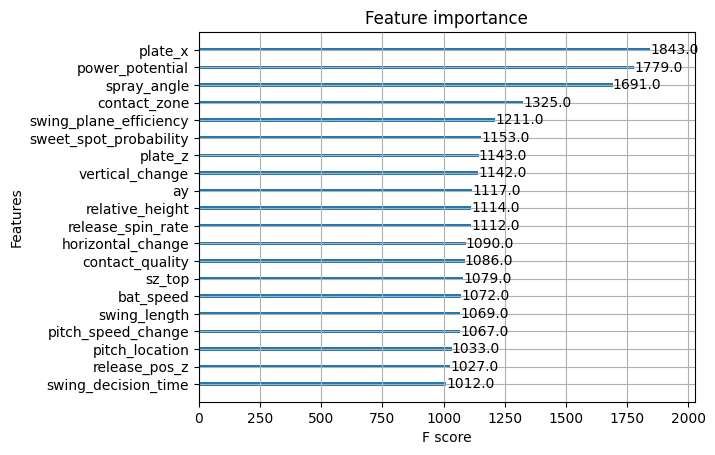

In [31]:
plot_importance(best_model, max_num_features=20)
plt.show()

In [58]:
importances = pd.Series(best_model.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
importances.tail(10)

pitch_type_CH             23.0
pitch_type_grouping_BB    22.0
pitch_type_ST             15.0
pitch_type_grouping_FB    15.0
pitch_type_CU             14.0
pitch_type_FS             13.0
pitch_type_grouping_OS    10.0
is_lhp                     6.0
pitch_type_FA              1.0
pitch_type_EP              1.0
dtype: float64

In [ ]:
### Setting up Optuna model optimization with XGBoost

def objective(trial):
    #suggested hyperparamters
    param = {
            "verbosity": 0,
            "objective": "multi:softmax",
            # use exact for small dataset.
            "tree_method": "exact",
            # defines booster, gblinear for linear functions.
            "booster": "gbtree", #performed better than 'gblinear' and 'dart'
            # L2 regularization weight.
            "lambda": trial.suggest_float("lambda", .01, 1.0, log=True),
            # L1 regularization weight.
            "alpha": trial.suggest_float("alpha", 1e-6, 1e-4, log=True),
            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.6, .9),
            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, .6),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 6, 12, step=1),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 5, 10),
            "eta": trial.suggest_float("eta", .025, .75, log=True),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1e-4, log=True),
            "grow_policy": "lossguide"
            }

    # Train and evaluate model
    model = XGBClassifier(**param, random_state=303)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    score = roc_auc_score(y_true= y_test, y_score= y_proba, average='macro', multi_class='ovr')
    return score


# Pruning Strategy
pruner = optuna.pruners.MedianPruner()

# Create study object
study_2 = optuna.create_study(direction="maximize", pruner=pruner)

# Run and Optimize the objective function
study_2.optimize(objective, n_trials=100, 
                #timeout=600
                )

print("Number of finished trials: ", len(study_2.trials))
print("Best trial:")
trial_2 = study_2.best_trial

print("  AUC Score: {}".format(trial_2.value))
print("  Params: ")
for key, value in trial_2.params.items():
    print("    {}: {}".format(key, value))